# Neural network classifier demonstration

Last revised: 10-Oct-2020 by Christian Forssén [christian.forssen@chalmers.se]

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Not really needed, but nicer plots
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

## Developing a code for doing neural networks with back propagation

One can identify a set of key steps when using neural networks to solve supervised learning problems:  
  
1. Collect and pre-process data  
1. Define model and architecture  
1. Choose cost function and optimizer  
1. Train the model  
1. Evaluate model performance on test data  
1. Adjust hyperparameters (if necessary, network architecture)

The exercise "build-your-own neural network" provides a step-by-step guided recipe for coding a neural network from scratch in python.

## Introduction to tensorflow
This short introduction uses Keras to:
* Build a neural network that classifies images.
* Train this neural network.
* And, finally, evaluate the accuracy of the model.

See [https://www.tensorflow.org/tutorials/quickstart/beginner](https://www.tensorflow.org/tutorials/quickstart/beginner) for more details

See also the [Tensorflow classification tutorial](https://www.tensorflow.org/tutorials/keras/classification)

In [2]:
# Install TensorFlow by updating the conda environment

import tensorflow as tf
print('You have tensorflow version:', tf.__version__, '(must be at least 2.0.0)')

You have tensorflow version: 2.6.0 (must be at least 2.0.0)


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. 

### Explore the data

In [4]:
# The shape of the training data
x_train.shape

(60000, 28, 28)

In [5]:
# Each training label is an integer
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

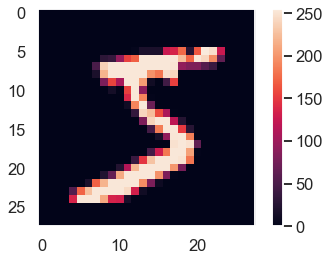

In [6]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

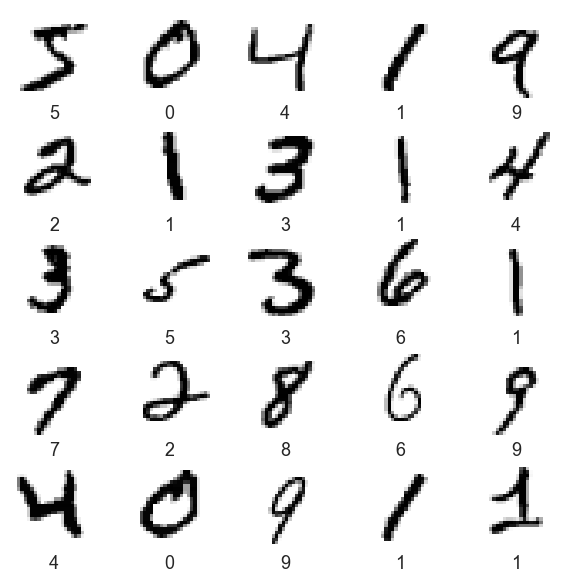

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[i]))


### Build the network

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), have parameters that are learned during training.

Build the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model by stacking layers. Choose an optimizer and loss function for training:

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

2021-09-23 13:02:14.927285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The first layer in this network, [`tf.keras.layers.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists two [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer is a 10-node softmax layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

In between the Dense layers is a [`tf.keras.layers.Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

We can print a summary of the model that also shows the number of parameters.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Other useful commands for storing and retrieving tensorflow models are:
- For saving a `model` after training: `tf.keras.models.save_model(model, 'filename.h5')`
- For load a pre-trained model: `tf.keras.models.load_model('filename.h5')`

which uses the compact, binary `hdf5`: https://www.hdfgroup.org/solutions/hdf5/ file format.

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* *Loss function* — This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* — This is how the model is updated based on the data it sees and its loss function.
* *Metrics* — Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified. 

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train and evaluate the model:

The simplest way to fit data is to just specify a number of epochs. During training the data will be fed through the network this many times.

In [12]:
history = model.fit(x_train, y_train, epochs=10)

2021-09-23 13:02:15.108176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


   1/1875 [..............................] - ETA: 9:32 - loss: 2.5024 - accuracy: 0.0625

  23/1875 [..............................] - ETA: 4s - loss: 1.7761 - accuracy: 0.4565  

  55/1875 [..............................] - ETA: 3s - loss: 1.2560 - accuracy: 0.6403

  70/1875 [>.............................] - ETA: 3s - loss: 1.1095 - accuracy: 0.6857

 104/1875 [>.............................] - ETA: 3s - loss: 0.9450 - accuracy: 0.7284

 135/1875 [=>............................] - ETA: 3s - loss: 0.8356 - accuracy: 0.7609

 168/1875 [=>............................] - ETA: 3s - loss: 0.7568 - accuracy: 0.7827

 196/1875 [==>...........................] - ETA: 3s - loss: 0.7079 - accuracy: 0.7962

 218/1875 [==>...........................] - ETA: 3s - loss: 0.6771 - accuracy: 0.8050

 249/1875 [==>...........................] - ETA: 3s - loss: 0.6453 - accuracy: 0.8143

 284/1875 [===>..........................] - ETA: 2s - loss: 0.6125 - accuracy: 0.8252

 317/1875 [====>.........................] - ETA: 2s - loss: 0.5871 - accuracy: 0.8322

 354/1875 [====>.........................] - ETA: 2s - loss: 0.5621 - accuracy: 0.8392

 394/1875 [=====>........................] - ETA: 2s - loss: 0.5403 - accuracy: 0.8454

 430/1875 [=====>........................] - ETA: 2s - loss: 0.5223 - accuracy: 0.8503

 470/1875 [======>.......................] - ETA: 2s - loss: 0.5065 - accuracy: 0.8541

 509/1875 [=======>......................] - ETA: 2s - loss: 0.4906 - accuracy: 0.8595

 550/1875 [=======>......................] - ETA: 2s - loss: 0.4774 - accuracy: 0.8637

 592/1875 [========>.....................] - ETA: 1s - loss: 0.4625 - accuracy: 0.8679

 631/1875 [=========>....................] - ETA: 1s - loss: 0.4527 - accuracy: 0.8710

 671/1875 [=========>....................] - ETA: 1s - loss: 0.4413 - accuracy: 0.8740

 712/1875 [==========>...................] - ETA: 1s - loss: 0.4305 - accuracy: 0.8772

 756/1875 [===========>..................] - ETA: 1s - loss: 0.4226 - accuracy: 0.8795

 799/1875 [===========>..................] - ETA: 1s - loss: 0.4136 - accuracy: 0.8822

 839/1875 [============>.................] - ETA: 1s - loss: 0.4083 - accuracy: 0.8840

 877/1875 [=============>................] - ETA: 1s - loss: 0.4006 - accuracy: 0.8862

 914/1875 [=============>................] - ETA: 1s - loss: 0.3942 - accuracy: 0.8879

 957/1875 [==============>...............] - ETA: 1s - loss: 0.3880 - accuracy: 0.8899

1002/1875 [===============>..............] - ETA: 1s - loss: 0.3809 - accuracy: 0.8918

1048/1875 [===============>..............] - ETA: 1s - loss: 0.3743 - accuracy: 0.8933

1094/1875 [================>.............] - ETA: 1s - loss: 0.3675 - accuracy: 0.8950

1139/1875 [=================>............] - ETA: 1s - loss: 0.3610 - accuracy: 0.8969

1183/1875 [=================>............] - ETA: 0s - loss: 0.3548 - accuracy: 0.8985



1221/1875 [==================>...........] - ETA: 0s - loss: 0.3499 - accuracy: 0.8997

1260/1875 [===================>..........] - ETA: 0s - loss: 0.3467 - accuracy: 0.9005

1302/1875 [===================>..........] - ETA: 0s - loss: 0.3416 - accuracy: 0.9020

1341/1875 [====================>.........] - ETA: 0s - loss: 0.3380 - accuracy: 0.9031

1382/1875 [=====================>........] - ETA: 0s - loss: 0.3340 - accuracy: 0.9043

1428/1875 [=====================>........] - ETA: 0s - loss: 0.3300 - accuracy: 0.9056

1468/1875 [======================>.......] - ETA: 0s - loss: 0.3260 - accuracy: 0.9067

1513/1875 [=======================>......] - ETA: 0s - loss: 0.3223 - accuracy: 0.9078

1558/1875 [=======================>......] - ETA: 0s - loss: 0.3196 - accuracy: 0.9085

1599/1875 [========================>.....] - ETA: 0s - loss: 0.3164 - accuracy: 0.9093

1645/1875 [=========================>....] - ETA: 0s - loss: 0.3124 - accuracy: 0.9104

1689/1875 [==========================>...] - ETA: 0s - loss: 0.3093 - accuracy: 0.9112

1733/1875 [==========================>...] - ETA: 0s - loss: 0.3069 - accuracy: 0.9119

1780/1875 [===========================>..] - ETA: 0s - loss: 0.3035 - accuracy: 0.9129

1822/1875 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.9136

1867/1875 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.9147

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2966 - accuracy: 0.9148


Epoch 2/10
   1/1875 [..............................] - ETA: 2s - loss: 0.5893 - accuracy: 0.8438

  46/1875 [..............................] - ETA: 2s - loss: 0.1593 - accuracy: 0.9538

  88/1875 [>.............................] - ETA: 2s - loss: 0.1547 - accuracy: 0.9545

 134/1875 [=>............................] - ETA: 1s - loss: 0.1569 - accuracy: 0.9543

 177/1875 [=>............................] - ETA: 1s - loss: 0.1565 - accuracy: 0.9544

 220/1875 [==>...........................] - ETA: 1s - loss: 0.1561 - accuracy: 0.9553

 266/1875 [===>..........................] - ETA: 1s - loss: 0.1576 - accuracy: 0.9543

 306/1875 [===>..........................] - ETA: 1s - loss: 0.1560 - accuracy: 0.9549

 352/1875 [====>.........................] - ETA: 1s - loss: 0.1563 - accuracy: 0.9552

 399/1875 [=====>........................] - ETA: 1s - loss: 0.1578 - accuracy: 0.9549

 438/1875 [======>.......................] - ETA: 1s - loss: 0.1587 - accuracy: 0.9545

 483/1875 [======>.......................] - ETA: 1s - loss: 0.1601 - accuracy: 0.9540

 527/1875 [=======>......................] - ETA: 1s - loss: 0.1596 - accuracy: 0.9540

 570/1875 [========>.....................] - ETA: 1s - loss: 0.1574 - accuracy: 0.9544

 617/1875 [========>.....................] - ETA: 1s - loss: 0.1565 - accuracy: 0.9546

 660/1875 [=========>....................] - ETA: 1s - loss: 0.1554 - accuracy: 0.9547

 705/1875 [==========>...................] - ETA: 1s - loss: 0.1536 - accuracy: 0.9550

 752/1875 [===========>..................] - ETA: 1s - loss: 0.1545 - accuracy: 0.9545

 791/1875 [===========>..................] - ETA: 1s - loss: 0.1555 - accuracy: 0.9543

 837/1875 [============>.................] - ETA: 1s - loss: 0.1549 - accuracy: 0.9545



 883/1875 [=============>................] - ETA: 1s - loss: 0.1548 - accuracy: 0.9546

 925/1875 [=============>................] - ETA: 1s - loss: 0.1542 - accuracy: 0.9549

 971/1875 [==============>...............] - ETA: 1s - loss: 0.1533 - accuracy: 0.9551

1014/1875 [===============>..............] - ETA: 0s - loss: 0.1531 - accuracy: 0.9551

1058/1875 [===============>..............] - ETA: 0s - loss: 0.1520 - accuracy: 0.9556

1105/1875 [================>.............] - ETA: 0s - loss: 0.1511 - accuracy: 0.9559

1146/1875 [=================>............] - ETA: 0s - loss: 0.1508 - accuracy: 0.9560

1191/1875 [==================>...........] - ETA: 0s - loss: 0.1511 - accuracy: 0.9559

1236/1875 [==================>...........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9561

1276/1875 [===================>..........] - ETA: 0s - loss: 0.1493 - accuracy: 0.9563

1322/1875 [====================>.........] - ETA: 0s - loss: 0.1479 - accuracy: 0.9566

1367/1875 [====================>.........] - ETA: 0s - loss: 0.1471 - accuracy: 0.9569

1410/1875 [=====================>........] - ETA: 0s - loss: 0.1463 - accuracy: 0.9572

1457/1875 [======================>.......] - ETA: 0s - loss: 0.1457 - accuracy: 0.9572

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1460 - accuracy: 0.9572

1542/1875 [=======================>......] - ETA: 0s - loss: 0.1460 - accuracy: 0.9573

1588/1875 [========================>.....] - ETA: 0s - loss: 0.1462 - accuracy: 0.9571

1628/1875 [=========================>....] - ETA: 0s - loss: 0.1459 - accuracy: 0.9572

1674/1875 [=========================>....] - ETA: 0s - loss: 0.1461 - accuracy: 0.9572

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1456 - accuracy: 0.9575

1761/1875 [===========================>..] - ETA: 0s - loss: 0.1448 - accuracy: 0.9576

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1442 - accuracy: 0.9576



1851/1875 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9576

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1437 - accuracy: 0.9577


Epoch 3/10
   1/1875 [..............................] - ETA: 2s - loss: 0.1774 - accuracy: 0.9062

  48/1875 [..............................] - ETA: 1s - loss: 0.1110 - accuracy: 0.9668

  93/1875 [>.............................] - ETA: 1s - loss: 0.1066 - accuracy: 0.9654

 136/1875 [=>............................] - ETA: 1s - loss: 0.1035 - accuracy: 0.9671

 181/1875 [=>............................] - ETA: 1s - loss: 0.1114 - accuracy: 0.9653

 223/1875 [==>...........................] - ETA: 1s - loss: 0.1138 - accuracy: 0.9650

 269/1875 [===>..........................] - ETA: 1s - loss: 0.1117 - accuracy: 0.9660

 315/1875 [====>.........................] - ETA: 1s - loss: 0.1103 - accuracy: 0.9663

 355/1875 [====>.........................] - ETA: 1s - loss: 0.1126 - accuracy: 0.9654

 400/1875 [=====>........................] - ETA: 1s - loss: 0.1128 - accuracy: 0.9656

 445/1875 [======>.......................] - ETA: 1s - loss: 0.1145 - accuracy: 0.9648

 485/1875 [======>.......................] - ETA: 1s - loss: 0.1122 - accuracy: 0.9655

 529/1875 [=======>......................] - ETA: 1s - loss: 0.1120 - accuracy: 0.9657

 572/1875 [========>.....................] - ETA: 1s - loss: 0.1121 - accuracy: 0.9657

 616/1875 [========>.....................] - ETA: 1s - loss: 0.1119 - accuracy: 0.9659

 661/1875 [=========>....................] - ETA: 1s - loss: 0.1113 - accuracy: 0.9666

 703/1875 [==========>...................] - ETA: 1s - loss: 0.1112 - accuracy: 0.9664

 748/1875 [==========>...................] - ETA: 1s - loss: 0.1105 - accuracy: 0.9665

 795/1875 [===========>..................] - ETA: 1s - loss: 0.1108 - accuracy: 0.9665

 835/1875 [============>.................] - ETA: 1s - loss: 0.1114 - accuracy: 0.9665

 881/1875 [=============>................] - ETA: 1s - loss: 0.1114 - accuracy: 0.9664

 926/1875 [=============>................] - ETA: 1s - loss: 0.1114 - accuracy: 0.9664

 970/1875 [==============>...............] - ETA: 1s - loss: 0.1112 - accuracy: 0.9666

1017/1875 [===============>..............] - ETA: 0s - loss: 0.1104 - accuracy: 0.9669

1060/1875 [===============>..............] - ETA: 0s - loss: 0.1105 - accuracy: 0.9666

1105/1875 [================>.............] - ETA: 0s - loss: 0.1107 - accuracy: 0.9667

1151/1875 [=================>............] - ETA: 0s - loss: 0.1110 - accuracy: 0.9665

1191/1875 [==================>...........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9668

1236/1875 [==================>...........] - ETA: 0s - loss: 0.1098 - accuracy: 0.9668

1281/1875 [===================>..........] - ETA: 0s - loss: 0.1103 - accuracy: 0.9667

1321/1875 [====================>.........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9669

1367/1875 [====================>.........] - ETA: 0s - loss: 0.1101 - accuracy: 0.9670

1411/1875 [=====================>........] - ETA: 0s - loss: 0.1105 - accuracy: 0.9671

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1099 - accuracy: 0.9673

1501/1875 [=======================>......] - ETA: 0s - loss: 0.1099 - accuracy: 0.9673

1542/1875 [=======================>......] - ETA: 0s - loss: 0.1097 - accuracy: 0.9673

1587/1875 [========================>.....] - ETA: 0s - loss: 0.1098 - accuracy: 0.9673

1632/1875 [=========================>....] - ETA: 0s - loss: 0.1099 - accuracy: 0.9673

1671/1875 [=========================>....] - ETA: 0s - loss: 0.1100 - accuracy: 0.9673

1716/1875 [==========================>...] - ETA: 0s - loss: 0.1101 - accuracy: 0.9674

1761/1875 [===========================>..] - ETA: 0s - loss: 0.1093 - accuracy: 0.9675

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1091 - accuracy: 0.9676

1850/1875 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9676

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1088 - accuracy: 0.9676


Epoch 4/10
   1/1875 [..............................] - ETA: 4s - loss: 0.1097 - accuracy: 0.9688

  43/1875 [..............................] - ETA: 2s - loss: 0.0897 - accuracy: 0.9724

  90/1875 [>.............................] - ETA: 2s - loss: 0.0861 - accuracy: 0.9715

 134/1875 [=>............................] - ETA: 1s - loss: 0.0829 - accuracy: 0.9713

 176/1875 [=>............................] - ETA: 1s - loss: 0.0859 - accuracy: 0.9716

 221/1875 [==>...........................] - ETA: 1s - loss: 0.0880 - accuracy: 0.9706

 262/1875 [===>..........................] - ETA: 1s - loss: 0.0909 - accuracy: 0.9696

 307/1875 [===>..........................] - ETA: 1s - loss: 0.0918 - accuracy: 0.9697

 354/1875 [====>.........................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9699

 395/1875 [=====>........................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9705

 441/1875 [======>.......................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9705

 486/1875 [======>.......................] - ETA: 1s - loss: 0.0902 - accuracy: 0.9707

 527/1875 [=======>......................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9706

 574/1875 [========>.....................] - ETA: 1s - loss: 0.0882 - accuracy: 0.9713

 616/1875 [========>.....................] - ETA: 1s - loss: 0.0895 - accuracy: 0.9711

 660/1875 [=========>....................] - ETA: 1s - loss: 0.0905 - accuracy: 0.9709

 705/1875 [==========>...................] - ETA: 1s - loss: 0.0906 - accuracy: 0.9711

 742/1875 [==========>...................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9713

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0900 - accuracy: 0.9717

 820/1875 [============>.................] - ETA: 1s - loss: 0.0905 - accuracy: 0.9718

 862/1875 [============>.................] - ETA: 1s - loss: 0.0899 - accuracy: 0.9719

 908/1875 [=============>................] - ETA: 1s - loss: 0.0889 - accuracy: 0.9722

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0883 - accuracy: 0.9721

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0890 - accuracy: 0.9720

1042/1875 [===============>..............] - ETA: 0s - loss: 0.0890 - accuracy: 0.9721

1085/1875 [================>.............] - ETA: 0s - loss: 0.0878 - accuracy: 0.9722

1129/1875 [=================>............] - ETA: 0s - loss: 0.0876 - accuracy: 0.9724

1175/1875 [=================>............] - ETA: 0s - loss: 0.0885 - accuracy: 0.9722

1215/1875 [==================>...........] - ETA: 0s - loss: 0.0882 - accuracy: 0.9724

1261/1875 [===================>..........] - ETA: 0s - loss: 0.0887 - accuracy: 0.9721

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0884 - accuracy: 0.9721

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9720

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9721



1436/1875 [=====================>........] - ETA: 0s - loss: 0.0889 - accuracy: 0.9720

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0889 - accuracy: 0.9721

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0884 - accuracy: 0.9723

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0886 - accuracy: 0.9724

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0888 - accuracy: 0.9723

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0886 - accuracy: 0.9724

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0884 - accuracy: 0.9725

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0882 - accuracy: 0.9726

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0883 - accuracy: 0.9724

1828/1875 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9726

1873/1875 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9726

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0881 - accuracy: 0.9726


Epoch 5/10
   1/1875 [..............................] - ETA: 3s - loss: 0.1001 - accuracy: 0.9688

  44/1875 [..............................] - ETA: 2s - loss: 0.0589 - accuracy: 0.9801

  89/1875 [>.............................] - ETA: 2s - loss: 0.0635 - accuracy: 0.9782

 136/1875 [=>............................] - ETA: 1s - loss: 0.0657 - accuracy: 0.9768

 177/1875 [=>............................] - ETA: 1s - loss: 0.0694 - accuracy: 0.9772

 224/1875 [==>...........................] - ETA: 1s - loss: 0.0695 - accuracy: 0.9773

 269/1875 [===>..........................] - ETA: 1s - loss: 0.0740 - accuracy: 0.9758

 310/1875 [===>..........................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9767

 356/1875 [====>.........................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9771

 399/1875 [=====>........................] - ETA: 1s - loss: 0.0725 - accuracy: 0.9768

 441/1875 [======>.......................] - ETA: 1s - loss: 0.0724 - accuracy: 0.9764

 487/1875 [======>.......................] - ETA: 1s - loss: 0.0727 - accuracy: 0.9764

 529/1875 [=======>......................] - ETA: 1s - loss: 0.0725 - accuracy: 0.9763

 574/1875 [========>.....................] - ETA: 1s - loss: 0.0742 - accuracy: 0.9760

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9760

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0749 - accuracy: 0.9759

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9759

 748/1875 [==========>...................] - ETA: 1s - loss: 0.0732 - accuracy: 0.9765

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9765

 836/1875 [============>.................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9765



 879/1875 [=============>................] - ETA: 1s - loss: 0.0731 - accuracy: 0.9765

 922/1875 [=============>................] - ETA: 1s - loss: 0.0734 - accuracy: 0.9765

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0733 - accuracy: 0.9762

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0730 - accuracy: 0.9764

1053/1875 [===============>..............] - ETA: 0s - loss: 0.0741 - accuracy: 0.9761

1099/1875 [================>.............] - ETA: 0s - loss: 0.0749 - accuracy: 0.9759

1140/1875 [=================>............] - ETA: 0s - loss: 0.0755 - accuracy: 0.9756

1186/1875 [=================>............] - ETA: 0s - loss: 0.0755 - accuracy: 0.9757

1231/1875 [==================>...........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9756

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9754

1320/1875 [====================>.........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9756

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0756 - accuracy: 0.9757

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9757

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9758

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0757 - accuracy: 0.9758

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0766 - accuracy: 0.9755

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0765 - accuracy: 0.9756

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0771 - accuracy: 0.9753

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0770 - accuracy: 0.9754

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0773 - accuracy: 0.9754

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0777 - accuracy: 0.9752

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0775 - accuracy: 0.9754

1841/1875 [============================>.] - ETA: 0s - loss: 0.0772 - accuracy: 0.9754

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0768 - accuracy: 0.9756


Epoch 6/10
   1/1875 [..............................] - ETA: 2s - loss: 0.0203 - accuracy: 1.0000

  48/1875 [..............................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9792

  88/1875 [>.............................] - ETA: 2s - loss: 0.0622 - accuracy: 0.9812

 133/1875 [=>............................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9814

 179/1875 [=>............................] - ETA: 1s - loss: 0.0613 - accuracy: 0.9804

 221/1875 [==>...........................] - ETA: 1s - loss: 0.0615 - accuracy: 0.9806

 267/1875 [===>..........................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9810

 312/1875 [===>..........................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9803

 354/1875 [====>.........................] - ETA: 1s - loss: 0.0616 - accuracy: 0.9803

 401/1875 [=====>........................] - ETA: 1s - loss: 0.0609 - accuracy: 0.9803



 443/1875 [======>.......................] - ETA: 1s - loss: 0.0623 - accuracy: 0.9799



 479/1875 [======>.......................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9800

 519/1875 [=======>......................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9805

 560/1875 [=======>......................] - ETA: 1s - loss: 0.0621 - accuracy: 0.9805

 606/1875 [========>.....................] - ETA: 1s - loss: 0.0619 - accuracy: 0.9805

 648/1875 [=========>....................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9809

 684/1875 [=========>....................] - ETA: 1s - loss: 0.0617 - accuracy: 0.9806

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0622 - accuracy: 0.9804

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9802

 817/1875 [============>.................] - ETA: 1s - loss: 0.0640 - accuracy: 0.9798

 864/1875 [============>.................] - ETA: 1s - loss: 0.0642 - accuracy: 0.9798

 906/1875 [=============>................] - ETA: 1s - loss: 0.0643 - accuracy: 0.9797

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0647 - accuracy: 0.9794

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0651 - accuracy: 0.9793

1041/1875 [===============>..............] - ETA: 0s - loss: 0.0651 - accuracy: 0.9794

1088/1875 [================>.............] - ETA: 0s - loss: 0.0650 - accuracy: 0.9795

1133/1875 [=================>............] - ETA: 0s - loss: 0.0652 - accuracy: 0.9794

1174/1875 [=================>............] - ETA: 0s - loss: 0.0648 - accuracy: 0.9795

1220/1875 [==================>...........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9795

1262/1875 [===================>..........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9795

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9795

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9793

1394/1875 [=====================>........] - ETA: 0s - loss: 0.0648 - accuracy: 0.9795

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0649 - accuracy: 0.9796

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0653 - accuracy: 0.9795

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0654 - accuracy: 0.9795

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0657 - accuracy: 0.9795

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796



1657/1875 [=========================>....] - ETA: 0s - loss: 0.0655 - accuracy: 0.9795

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796

1837/1875 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9796

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0657 - accuracy: 0.9795


Epoch 7/10


   1/1875 [..............................] - ETA: 2s - loss: 0.0241 - accuracy: 1.0000

  46/1875 [..............................] - ETA: 2s - loss: 0.0673 - accuracy: 0.9817

  91/1875 [>.............................] - ETA: 2s - loss: 0.0688 - accuracy: 0.9773

 132/1875 [=>............................] - ETA: 2s - loss: 0.0666 - accuracy: 0.9773

 178/1875 [=>............................] - ETA: 1s - loss: 0.0639 - accuracy: 0.9786

 222/1875 [==>...........................] - ETA: 1s - loss: 0.0630 - accuracy: 0.9790

 266/1875 [===>..........................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9796

 313/1875 [====>.........................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9791

 348/1875 [====>.........................] - ETA: 1s - loss: 0.0620 - accuracy: 0.9791

 380/1875 [=====>........................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9794

 417/1875 [=====>........................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9798

 454/1875 [======>.......................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9800

 502/1875 [=======>......................] - ETA: 1s - loss: 0.0592 - accuracy: 0.9798

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0606 - accuracy: 0.9792

 589/1875 [========>.....................] - ETA: 1s - loss: 0.0596 - accuracy: 0.9796

 635/1875 [=========>....................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9801

 678/1875 [=========>....................] - ETA: 1s - loss: 0.0590 - accuracy: 0.9799

 724/1875 [==========>...................] - ETA: 1s - loss: 0.0586 - accuracy: 0.9799

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0585 - accuracy: 0.9802

 811/1875 [===========>..................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9804

 857/1875 [============>.................] - ETA: 1s - loss: 0.0584 - accuracy: 0.9805

 901/1875 [=============>................] - ETA: 1s - loss: 0.0580 - accuracy: 0.9808

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9806

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0588 - accuracy: 0.9806

1032/1875 [===============>..............] - ETA: 0s - loss: 0.0590 - accuracy: 0.9804

1075/1875 [================>.............] - ETA: 0s - loss: 0.0587 - accuracy: 0.9806

1121/1875 [================>.............] - ETA: 0s - loss: 0.0589 - accuracy: 0.9805

1163/1875 [=================>............] - ETA: 0s - loss: 0.0584 - accuracy: 0.9807

1209/1875 [==================>...........] - ETA: 0s - loss: 0.0582 - accuracy: 0.9808

1255/1875 [===================>..........] - ETA: 0s - loss: 0.0583 - accuracy: 0.9808

1297/1875 [===================>..........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9808

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0582 - accuracy: 0.9809

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0586 - accuracy: 0.9807

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0587 - accuracy: 0.9808

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0584 - accuracy: 0.9808

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0588 - accuracy: 0.9808

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0588 - accuracy: 0.9808

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9807

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0591 - accuracy: 0.9807

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9805



1744/1875 [==========================>...] - ETA: 0s - loss: 0.0598 - accuracy: 0.9805

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9805

1833/1875 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9804

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0601 - accuracy: 0.9804


Epoch 8/10


   1/1875 [..............................] - ETA: 4s - loss: 0.1210 - accuracy: 0.9688

  46/1875 [..............................] - ETA: 2s - loss: 0.0682 - accuracy: 0.9817

  94/1875 [>.............................] - ETA: 1s - loss: 0.0529 - accuracy: 0.9850

 136/1875 [=>............................] - ETA: 1s - loss: 0.0495 - accuracy: 0.9862

 182/1875 [=>............................] - ETA: 1s - loss: 0.0471 - accuracy: 0.9856

 229/1875 [==>...........................] - ETA: 1s - loss: 0.0454 - accuracy: 0.9855



 271/1875 [===>..........................] - ETA: 1s - loss: 0.0462 - accuracy: 0.9854

 317/1875 [====>.........................] - ETA: 1s - loss: 0.0461 - accuracy: 0.9853



 363/1875 [====>.........................] - ETA: 1s - loss: 0.0476 - accuracy: 0.9845

 407/1875 [=====>........................] - ETA: 1s - loss: 0.0474 - accuracy: 0.9847

 455/1875 [======>.......................] - ETA: 1s - loss: 0.0477 - accuracy: 0.9847

 498/1875 [======>.......................] - ETA: 1s - loss: 0.0476 - accuracy: 0.9848

 541/1875 [=======>......................] - ETA: 1s - loss: 0.0474 - accuracy: 0.9848

 587/1875 [========>.....................] - ETA: 1s - loss: 0.0477 - accuracy: 0.9845

 627/1875 [=========>....................] - ETA: 1s - loss: 0.0478 - accuracy: 0.9842

 673/1875 [=========>....................] - ETA: 1s - loss: 0.0492 - accuracy: 0.9836

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0496 - accuracy: 0.9834

 761/1875 [===========>..................] - ETA: 1s - loss: 0.0500 - accuracy: 0.9835

 808/1875 [===========>..................] - ETA: 1s - loss: 0.0495 - accuracy: 0.9835

 852/1875 [============>.................] - ETA: 1s - loss: 0.0505 - accuracy: 0.9833

 898/1875 [=============>................] - ETA: 1s - loss: 0.0507 - accuracy: 0.9833

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0513 - accuracy: 0.9830

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0509 - accuracy: 0.9832

1031/1875 [===============>..............] - ETA: 0s - loss: 0.0508 - accuracy: 0.9831

1077/1875 [================>.............] - ETA: 0s - loss: 0.0514 - accuracy: 0.9831

1118/1875 [================>.............] - ETA: 0s - loss: 0.0519 - accuracy: 0.9829

1165/1875 [=================>............] - ETA: 0s - loss: 0.0516 - accuracy: 0.9829

1210/1875 [==================>...........] - ETA: 0s - loss: 0.0515 - accuracy: 0.9831

1254/1875 [===================>..........] - ETA: 0s - loss: 0.0520 - accuracy: 0.9829

1300/1875 [===================>..........] - ETA: 0s - loss: 0.0527 - accuracy: 0.9827

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0529 - accuracy: 0.9826

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0524 - accuracy: 0.9828

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0533 - accuracy: 0.9826

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0534 - accuracy: 0.9825

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0541 - accuracy: 0.9823

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0542 - accuracy: 0.9822

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0538 - accuracy: 0.9824

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0542 - accuracy: 0.9823

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0541 - accuracy: 0.9823

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0539 - accuracy: 0.9822

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9822

1828/1875 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9821

1874/1875 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9822

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0546 - accuracy: 0.9822


Epoch 9/10
   1/1875 [..............................] - ETA: 3s - loss: 0.0075 - accuracy: 1.0000

  46/1875 [..............................] - ETA: 2s - loss: 0.0464 - accuracy: 0.9837

  88/1875 [>.............................] - ETA: 2s - loss: 0.0459 - accuracy: 0.9854

 134/1875 [=>............................] - ETA: 1s - loss: 0.0389 - accuracy: 0.9881

 177/1875 [=>............................] - ETA: 1s - loss: 0.0408 - accuracy: 0.9864

 220/1875 [==>...........................] - ETA: 1s - loss: 0.0429 - accuracy: 0.9859

 266/1875 [===>..........................] - ETA: 1s - loss: 0.0426 - accuracy: 0.9857

 307/1875 [===>..........................] - ETA: 1s - loss: 0.0417 - accuracy: 0.9860

 352/1875 [====>.........................] - ETA: 1s - loss: 0.0428 - accuracy: 0.9857

 387/1875 [=====>........................] - ETA: 1s - loss: 0.0433 - accuracy: 0.9857

 413/1875 [=====>........................] - ETA: 1s - loss: 0.0438 - accuracy: 0.9852

 459/1875 [======>.......................] - ETA: 1s - loss: 0.0445 - accuracy: 0.9855

 504/1875 [=======>......................] - ETA: 1s - loss: 0.0457 - accuracy: 0.9853

 547/1875 [=======>......................] - ETA: 1s - loss: 0.0468 - accuracy: 0.9847

 594/1875 [========>.....................] - ETA: 1s - loss: 0.0473 - accuracy: 0.9845

 635/1875 [=========>....................] - ETA: 1s - loss: 0.0463 - accuracy: 0.9850

 680/1875 [=========>....................] - ETA: 1s - loss: 0.0461 - accuracy: 0.9852

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0468 - accuracy: 0.9850

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0468 - accuracy: 0.9849

 814/1875 [============>.................] - ETA: 1s - loss: 0.0464 - accuracy: 0.9850

 860/1875 [============>.................] - ETA: 1s - loss: 0.0464 - accuracy: 0.9850

 902/1875 [=============>................] - ETA: 1s - loss: 0.0469 - accuracy: 0.9848

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0478 - accuracy: 0.9845

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0483 - accuracy: 0.9844

1034/1875 [===============>..............] - ETA: 0s - loss: 0.0479 - accuracy: 0.9846

1079/1875 [================>.............] - ETA: 0s - loss: 0.0473 - accuracy: 0.9848

1119/1875 [================>.............] - ETA: 0s - loss: 0.0471 - accuracy: 0.9848

1164/1875 [=================>............] - ETA: 0s - loss: 0.0482 - accuracy: 0.9846

1209/1875 [==================>...........] - ETA: 0s - loss: 0.0482 - accuracy: 0.9846

1250/1875 [===================>..........] - ETA: 0s - loss: 0.0479 - accuracy: 0.9848

1297/1875 [===================>..........] - ETA: 0s - loss: 0.0476 - accuracy: 0.9850

1342/1875 [====================>.........] - ETA: 0s - loss: 0.0481 - accuracy: 0.9848

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0477 - accuracy: 0.9850

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0482 - accuracy: 0.9848

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0483 - accuracy: 0.9849

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0482 - accuracy: 0.9849

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0481 - accuracy: 0.9847

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0484 - accuracy: 0.9845

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9844

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0489 - accuracy: 0.9843

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0490 - accuracy: 0.9843

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0491 - accuracy: 0.9842

1829/1875 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9843

1873/1875 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9844

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0487 - accuracy: 0.9844


Epoch 10/10
   1/1875 [..............................] - ETA: 2s - loss: 0.1837 - accuracy: 0.9062

  46/1875 [..............................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9817

  87/1875 [>.............................] - ETA: 2s - loss: 0.0416 - accuracy: 0.9874

 133/1875 [=>............................] - ETA: 1s - loss: 0.0408 - accuracy: 0.9873

 178/1875 [=>............................] - ETA: 1s - loss: 0.0409 - accuracy: 0.9863

 219/1875 [==>...........................] - ETA: 1s - loss: 0.0411 - accuracy: 0.9864

 265/1875 [===>..........................] - ETA: 1s - loss: 0.0414 - accuracy: 0.9866

 309/1875 [===>..........................] - ETA: 1s - loss: 0.0419 - accuracy: 0.9863

 353/1875 [====>.........................] - ETA: 1s - loss: 0.0437 - accuracy: 0.9858

 399/1875 [=====>........................] - ETA: 1s - loss: 0.0443 - accuracy: 0.9858

 440/1875 [======>.......................] - ETA: 1s - loss: 0.0455 - accuracy: 0.9854

 485/1875 [======>.......................] - ETA: 1s - loss: 0.0441 - accuracy: 0.9860

 531/1875 [=======>......................] - ETA: 1s - loss: 0.0432 - accuracy: 0.9862

 571/1875 [========>.....................] - ETA: 1s - loss: 0.0423 - accuracy: 0.9864

 617/1875 [========>.....................] - ETA: 1s - loss: 0.0421 - accuracy: 0.9866

 662/1875 [=========>....................] - ETA: 1s - loss: 0.0427 - accuracy: 0.9861

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0425 - accuracy: 0.9860

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0424 - accuracy: 0.9859

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0432 - accuracy: 0.9855

 837/1875 [============>.................] - ETA: 1s - loss: 0.0430 - accuracy: 0.9856

 883/1875 [=============>................] - ETA: 1s - loss: 0.0437 - accuracy: 0.9852

 923/1875 [=============>................] - ETA: 1s - loss: 0.0434 - accuracy: 0.9853

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0440 - accuracy: 0.9851

1015/1875 [===============>..............] - ETA: 0s - loss: 0.0444 - accuracy: 0.9850

1057/1875 [===============>..............] - ETA: 0s - loss: 0.0438 - accuracy: 0.9852

1103/1875 [================>.............] - ETA: 0s - loss: 0.0435 - accuracy: 0.9852

1147/1875 [=================>............] - ETA: 0s - loss: 0.0434 - accuracy: 0.9853

1190/1875 [==================>...........] - ETA: 0s - loss: 0.0438 - accuracy: 0.9851

1237/1875 [==================>...........] - ETA: 0s - loss: 0.0440 - accuracy: 0.9850

1278/1875 [===================>..........] - ETA: 0s - loss: 0.0443 - accuracy: 0.9850

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0440 - accuracy: 0.9851

1369/1875 [====================>.........] - ETA: 0s - loss: 0.0436 - accuracy: 0.9853

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0437 - accuracy: 0.9853

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0435 - accuracy: 0.9853

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0435 - accuracy: 0.9853

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0432 - accuracy: 0.9854

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0431 - accuracy: 0.9854

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0437 - accuracy: 0.9852

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0434 - accuracy: 0.9852

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0436 - accuracy: 0.9852

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0438 - accuracy: 0.9851

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0441 - accuracy: 0.9850

1845/1875 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0.9849

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0442 - accuracy: 0.9850


In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [14]:
history.history['accuracy']

[0.9148333072662354,
 0.9576500058174133,
 0.9676499962806702,
 0.9725666642189026,
 0.975600004196167,
 0.979533314704895,
 0.9804499745368958,
 0.9821833372116089,
 0.9843666553497314,
 0.9850000143051147]

### Evaluate accuracy
Next, compare how the model performs on the test dataset:

In [15]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0671 - accuracy: 0.9816



Test accuracy: 0.9815999865531921


### Make predictions
With the model trained, you can use it to make predictions about some images.

In [16]:
predictions = model.predict(x_test)

# Let's look at the prediction for the first test image
predictions[0]

array([8.9096147e-10, 8.7511834e-13, 5.8528418e-09, 7.4016252e-06,
       2.1436169e-13, 2.2765615e-08, 1.9437892e-18, 9.9999082e-01,
       1.4725519e-07, 1.6212994e-06], dtype=float32)

In [17]:
# Check the normalization of the output probabilities
np.sum(predictions[0])

0.99999994

In [18]:
# Which prob is largest?
np.argmax(predictions[0])

7

In [19]:
# Examining the test label shows that this classification is correct:
y_test[0]

7

In [20]:
# Some helper functions for nice plotting
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(str(predicted_label),
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

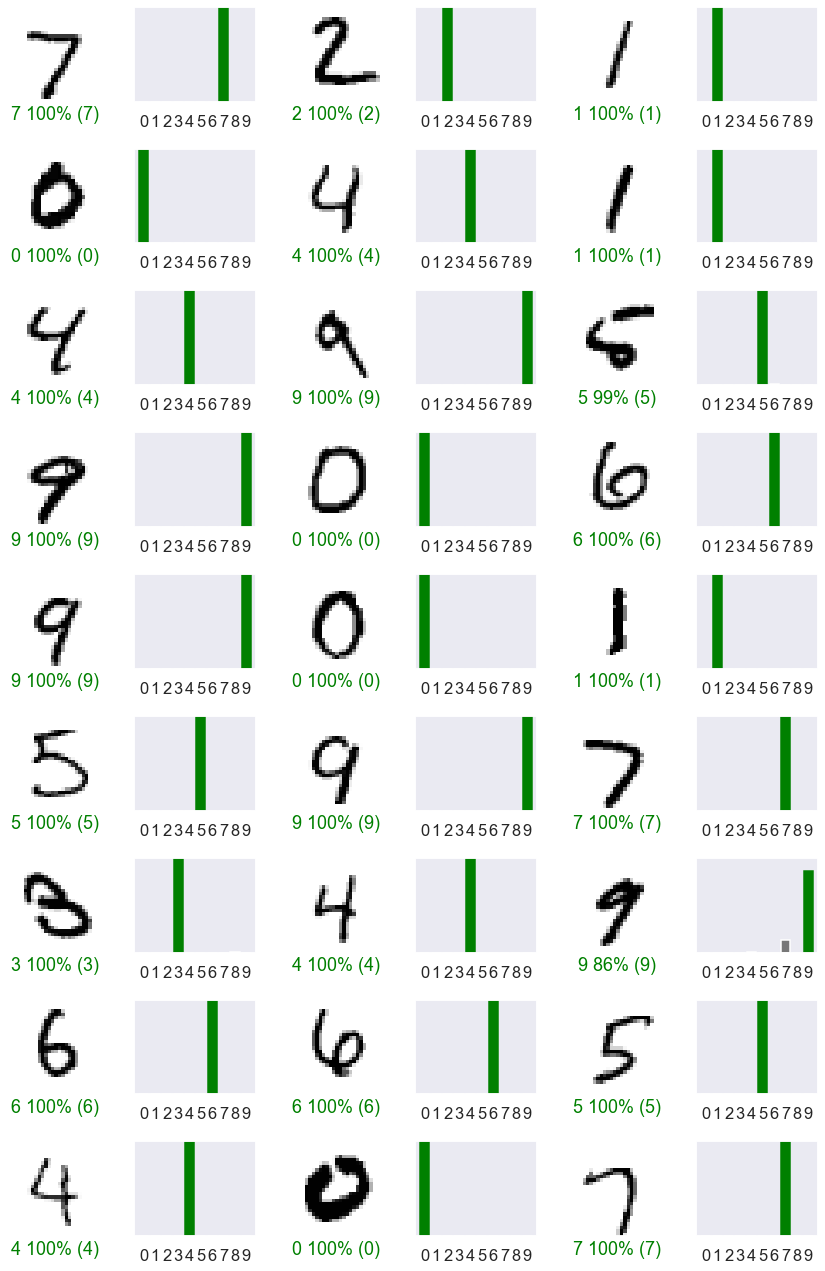

In [21]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 9
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()